In [37]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import autograd.numpy as np
from autograd import grad
from scipy.optimize import minimize
from scipy.stats import multivariate_normal
import autograd.numpy.random as npr

import autograd.scipy.stats.multivariate_normal as mvn
sns.set_style('white')
sns.set_context('notebook', font_scale=2, rc={'lines.linewidth': 2})
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [38]:
from psis import psislw 

In [39]:
import sys, os
sys.path.append('..')
sys.path.append('../..')
from viabel.vb import mean_field_gaussian_variational_family

In [56]:
def plot_contours(means, covs, colors=None, xlim=[-10,10], ylim=[-3, 3], corr=None, savepath=None):
    xlist = np.linspace(xlim[0], xlim[1], 100)
    ylist = np.linspace(ylim[0], ylim[1], 100)
    X,Y = np.meshgrid(xlist, ylist)
    XY = np.concatenate([X[:,:,np.newaxis], Y[:,:,np.newaxis]], axis=2)
    colors = colors or sns.color_palette()
    for m, c, col in zip(means, covs, colors):
        Z = multivariate_normal.pdf(XY, mean=m, cov=c)
        plt.contour(X, Y, Z, colors=[col], linestyles='solid')
    if corr is not None:
        plt.title('correlation = {:.2f}'.format(corr))
    if savepath is None:
        plt.savefig('../writing/variational-objectives/figures/kl-vb-corr-{:.2f}.pdf'.format(corr), 
                    bbox_inches='tight')
    else:
        plt.savefig(savepath, bbox_inches='tight')
            
            
    plt.show()

In [41]:
def gaussianKL(m1, c1, m2, c2):
    delta = m1 - m2
    p2 = np.linalg.inv(c2)
    return .5 * (np.trace(np.dot(c1, p2)) + np.dot(np.dot(delta, p2), delta)
                 - m1.size + np.log(np.linalg.det(c2)) - np.log(np.linalg.det(c1)))

In [74]:
def compute_inclusive_KL(m2, c2, var_family, optim_var_params, dim, n_samples=2000000, seed=40):
    L = np.linalg.cholesky(c2)
    my_rs = npr.RandomState(seed)
    samples = np.dot( my_rs.randn(n_samples, dim), L) + m2
    log_weights = mvn.logpdf(samples, m2, c2) - var_family.logdensity(samples, optim_var_params)
    _, paretok = psislw(log_weights)
    div = np.mean(log_weights)
    weights = np.exp(log_weights)
    div1 = -np.mean(weights*log_weights)
    #print('reverse paretok:', paretok)
    return div, paretok

def compute_KL_estimate(m2, c2, var_family, optim_var_params, dim, n_samples=2000000, seed=40):
    samples = var_family.sample(optim_var_params, n_samples, seed)
    log_weights = mvn.logpdf(samples, m2, c2) - var_family.logdensity(samples, optim_var_params)
    _, paretok = psislw(log_weights)
    div = -np.mean(log_weights)
    #print('kl paretok:', paretok)
    return div, paretok  

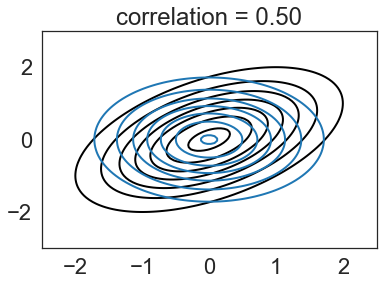

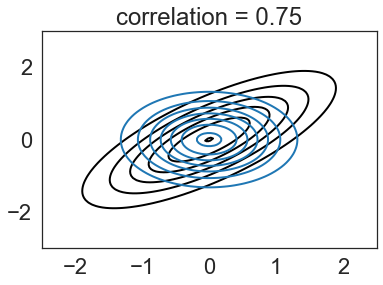

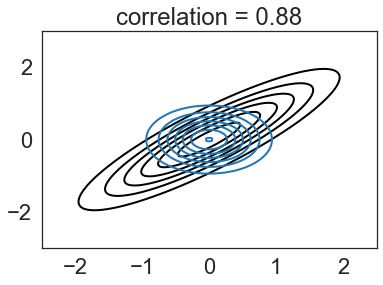

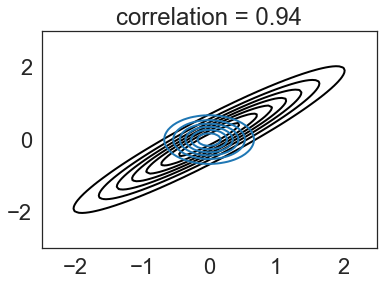

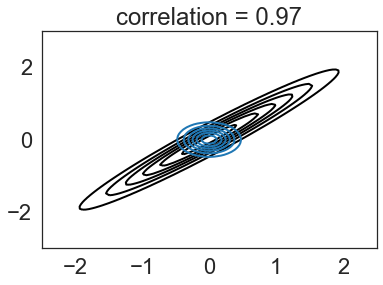

/anaconda3/envs/viabel_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: overflow encountered in multiply
  if __name__ == '__main__':


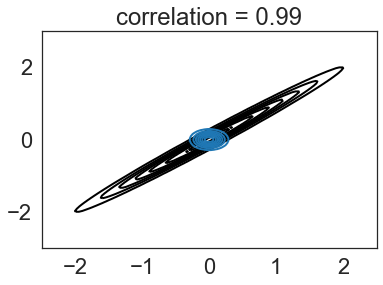

/anaconda3/envs/viabel_env/lib/python3.6/site-packages/numpy/core/_methods.py:151: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)


In [45]:
rhos = [.5, .75, .88, .94, .97, .99]
# rhos.reverse()
ds = np.concatenate([np.arange(2,10,2), np.arange(10,105,10,dtype=int)]) # np.arange(2,11,2,dtype=int)
df = pd.DataFrame(columns=['corr', 'd', 'KL', 'KL-samples', 'paretok'])
inc_df = pd.DataFrame(columns=['corr', 'd', 'KL', 'KL-samples', 'paretok'])

for rho in rhos:
    for d in ds:
        c2 = rho*np.ones((d,d))
        c2[np.diag_indices_from(c2)] = 1
        m2 = np.zeros(d)
        mf_g_var_family = mean_field_gaussian_variational_family(dim=d)
        def objective(logc1):
            c1 = np.diag(np.exp(logc1))
            return gaussianKL(m2, c1, m2, c2)
        res = minimize(objective, np.zeros(d), method='BFGS', jac=grad(objective))
        if d == 2:
            plot_contours(means=[m2]*2, covs=[c2, np.diag(np.exp(res.x))], 
                          colors=[(0.,0.,0.)]+sns.color_palette(),
                          xlim=[-2.5,2.5], corr=rho)
        
        init_var_param = np.concatenate([m2, np.array(res.x)/2])
        kl_val, paretok1 = compute_KL_estimate(m2, c2, mf_g_var_family, init_var_param, dim=d )
        df = df.append(dict(corr=rho, dimension=d, KL=res.fun, KL2 = kl_val, paretok=paretok1), ignore_index=True)
        inc_kl = gaussianKL(m2, c2, m2, np.diag(np.exp(res.x)) )
        
        inc_kl_est, paretok2 = compute_inclusive_KL(m2, c2, mf_g_var_family, init_var_param, dim=d )
        inc_df = inc_df.append(dict(corr=rho, dimension=d, KL=inc_kl, KL2=inc_kl_est, paretok=paretok2), ignore_index=True)

#### First we plot KL-divergence at the KLVI solution for increasing correlation and increasing dimensions

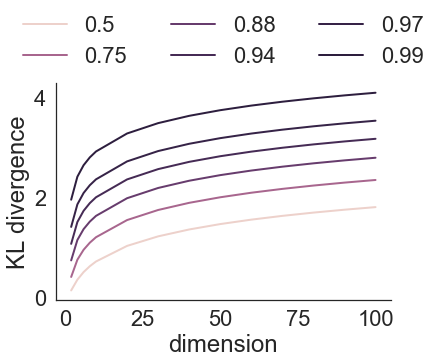

In [46]:
# sns.lineplot(data=df, x='corr', y='KL', hue='d', legend='full')
# plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
# sns.despine()
# plt.show()
sns.lineplot(data=df, x='dimension', y='KL', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-vb-d1.pdf', bbox_inches='tight')
plt.show()

#### Now we plot inclusive KL-divergence at the KLVI solution for increasing correlation and increasing dimensions

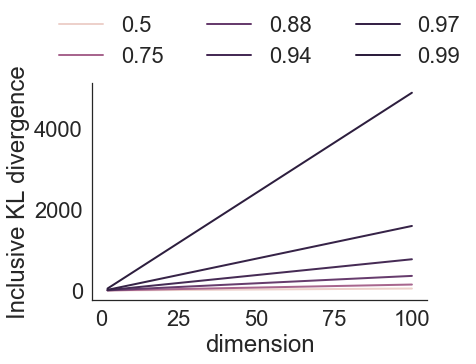

In [47]:
sns.lineplot(data=inc_df, x='dimension', y='KL', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Inclusive KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inckl-vb-d11.pdf', bbox_inches='tight')
plt.show()

#####   Here, we compute the Pareto-K for using the mean field approximation as the proposal 
and the correlated Gaussian as the target. This will show the finite sample behaviour and 
the effectiveness of the proposal as an IS-distribution ..
Since the approximation belongs to the Mean-field family, adn the target density is correlated, we see that the k-hat diagnostic does inform us about its inefficiency
Only when the target is low dimensional and has low-correlation, we obtain a Pareto-k less than 0.7 cutoff.


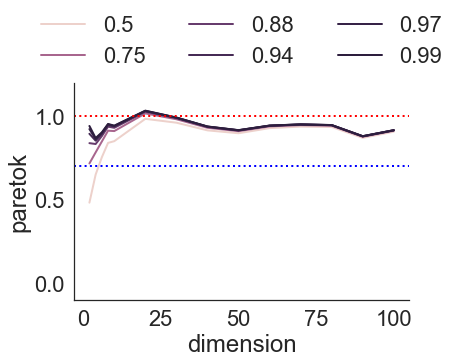

In [53]:
sns.lineplot(data=df, x='dimension', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('paretok')
plt.axhline(y=0.7, color='blue', linestyle=':')
plt.axhline(y=1.0, color='red', linestyle=':')
plt.ylim((-0.1, 1.2))
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-gaussian_gaussian_mean_field_paretok.pdf', bbox_inches='tight')
plt.show()

#####   Here, we compute the Pareto-K for using the obtained mean field approximation, where in 
we now sample from the target density, which is possible since the target is a multivariate Gaussian density, and then compute the Pareto-k on the weights obtained, it is quite obvious, that the Pareto-k will be high, since the target is so much more dispersed than the approximation. This is important since this is how the inclusive KL divergence is computed using MC samples. This clearly shows the need for an overdispersed distribution
as the IS-approximation.


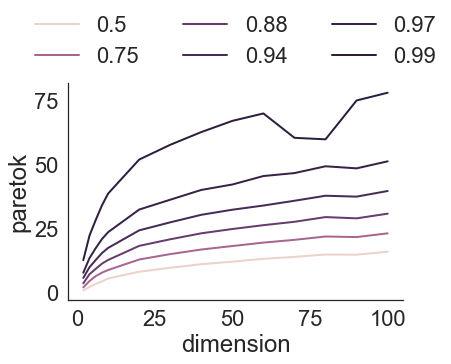

In [83]:
sns.lineplot(data=inc_df, x='dimension', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('paretok')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl-gaussian_gaussian_mean_field_reverse_paretok.pdf', bbox_inches='tight')
plt.show()

In [7]:
### Now at inclusive KLVI solution

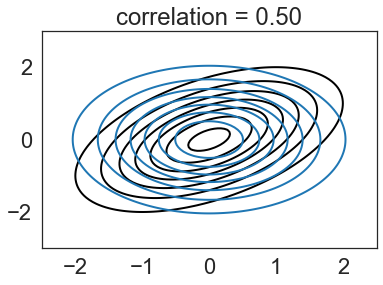

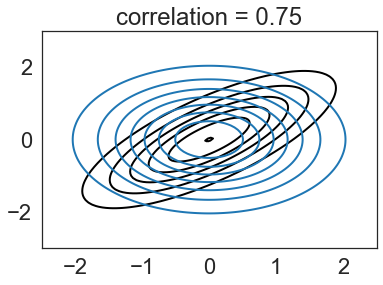

/anaconda3/envs/viabel_env/lib/python3.6/site-packages/numpy/core/fromnumeric.py:90: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


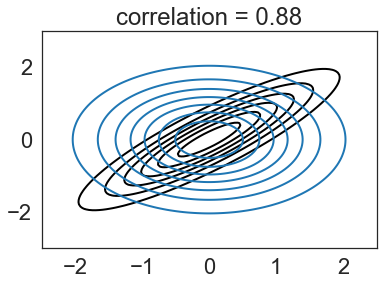

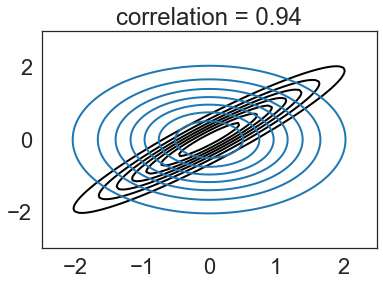

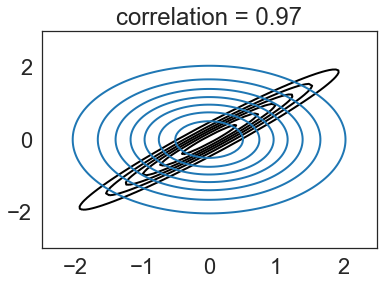

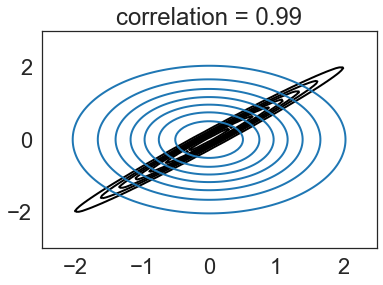

/Users/akashd/Desktop/research_repos/viabel/viabel/notebooks/psis.py:350: RuntimeWarning: overflow encountered in expm1
  np.expm1(x, out=x)


In [75]:
kl_inc_df = pd.DataFrame(columns=['corr', 'd', 'KL', 'KL2' 'paretok'])
inc_inc_df = pd.DataFrame(columns=['corr', 'd', 'KL', 'KL2', 'paretok'])

for rho in rhos:
    for d in ds:
        c2 = rho*np.ones((d,d))
        c2[np.diag_indices_from(c2)] = 1
        m2 = np.zeros(d)
        mf_g_var_family = mean_field_gaussian_variational_family(dim=d)
        def objective(logc1):
            c1 = np.diag(np.exp(logc1))
            return gaussianKL(m2, c2, m2, c1)
        res = minimize(objective, np.ones(d)*0.4, method='BFGS', jac=grad(objective))
        if d == 2:
            plot_contours(means=[m2]*2, covs=[c2, np.diag(np.exp(res.x))], 
                          colors=[(0.,0.,0.)]+sns.color_palette(),
                          xlim=[-2.5,2.5], corr=rho, savepath='../writing/variational-objectives/figures/inckl-vb-corr-{:.2f}.pdf'.format(rho))
        
        init_var_param = np.concatenate([m2, np.array(res.x)/2])
        kl_val, paretok1 = compute_KL_estimate(m2, c2, mf_g_var_family, init_var_param, dim=d )
        inc_kl_est, paretok2 = compute_inclusive_KL(m2, c2, mf_g_var_family, init_var_param, dim=d )
        inc_inc_df = inc_inc_df.append(dict(corr=rho, d=d, KL=res.fun, KL2 = inc_kl_est, paretok=paretok2), ignore_index=True)
        kl = gaussianKL( m2, np.diag(np.exp(res.x)), m2, c2 )
        kl_inc_df = kl_inc_df.append(dict(corr=rho, d=d, KL=kl, KL2=kl_val, paretok=paretok1), ignore_index=True)

#### Now we plot inclusive KL-divergence at the inclusive KLVI solution for increasing correlation and increasing dimensions

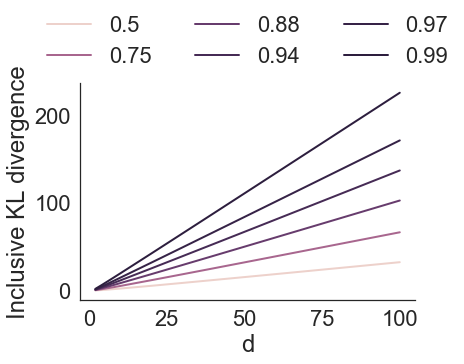

In [76]:
sns.lineplot(data=inc_inc_df, x='d', y='KL', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('Inclusive KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inc_kl_soln_inckl-vb-d1.pdf', bbox_inches='tight')
plt.show()

#### Now we plot KL-divergence at the inclusive KLVI solution for increasing correlation and increasing dimensions

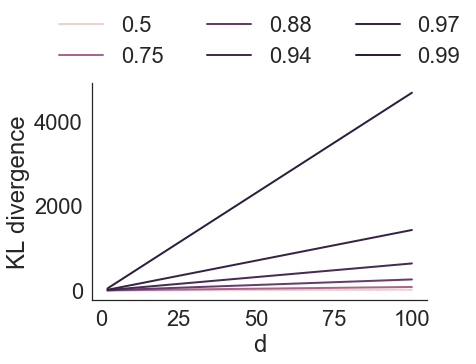

In [77]:
sns.lineplot(data=kl_inc_df, x='d', y='KL', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('KL divergence')
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/kl_at_inckl-vb-d1.pdf', bbox_inches='tight')
plt.show()

#####   Here, we compute the Pareto-K for using the mean field approximation obtained via minimising inclusive KL as the proposal and the correlated Gaussian as the target. This  shows the finite sample behaviour and 
the effectiveness of the proposal as an IS-distribution ..
Since the approximation belongs to the Mean-field family, and the true posterior is correlated, we see that the k-hat diagnostic does inform us about its inefficiency
Only target in low dimensions and low correlation have a Pareto-k less than 0.7 cutoff.
For all correlations, the cutoff of 0.7 is crossed at d=8, and the cutoff of 1.0 is reached at d=70 for rho=0.5, and d=20 for 0.75, and d=8 for rho=0.99.

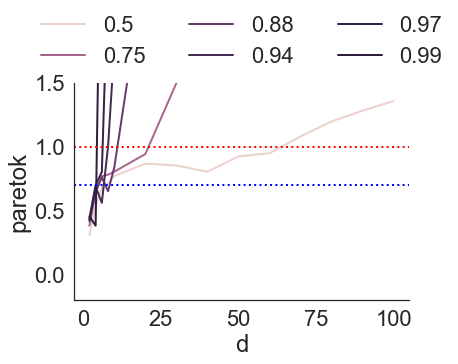

In [82]:
sns.lineplot(data=kl_inc_df, x='d', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('paretok')
plt.axhline(y=0.7, color='blue', linestyle=':')
plt.axhline(y=1.0, color='red', linestyle=':')
plt.ylim((-0.2, 1.5))
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inclusive_kl-gaussian_gaussian_mean_field_reverse_paretok.pdf', bbox_inches='tight')
plt.show()

#####   Here, we compute the Pareto-K for using the mean field approximation obtained via minimising inclusive KL as the proposal and the correlated Gaussian as the target. This time the samples are generated using the true posterior and the k-hat is computed using corresponding log-weights, in contrast to when we used the posterior samples with the KLVI solution, the log-weights have much lower k-hat and shows that it is a better distribution.But in higher dimensions, the improved efficiency slowly goes off and at d=50-60, the samples generated from the true density will not give the right MC estimate of inclusive KL.


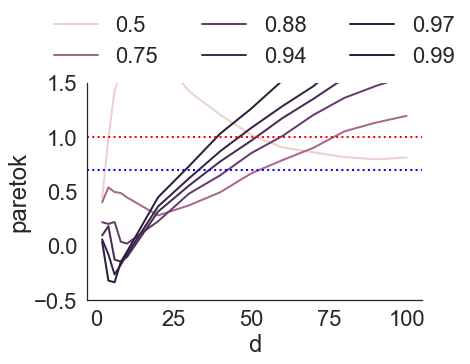

In [84]:

sns.lineplot(data=inc_inc_df, x='d', y='paretok', hue='corr', legend='full')
#plt.legend(rhos, bbox_to_anchor=(1.04,1), loc="upper left")
plt.ylabel('paretok')
plt.axhline(y=0.7, color='blue', linestyle=':')
plt.axhline(y=1.0, color='red', linestyle=':')
plt.ylim((-0.5, 1.5))
plt.legend(rhos, loc='upper center', bbox_to_anchor=(0.5, 1.4),
           ncol=3, frameon=False)
sns.despine()
plt.savefig('../writing/variational-objectives/figures/inclusive_kl-gaussian_gaussian_mean_field_paretok.pdf', bbox_inches='tight')
plt.show()

In [20]:
print(kl_inc_df.d[125], kl_inc_df.KL[125])

40.0 1842.0502150684729
